# Macroeconomía I

## Programación Dinámica e Iteración de la Función Valor

## (El Modelo Neoclásico de Crecimiento)

Mauricio M. Tejada

ILADES - Universidad Alberto Hurtado

### El Problema de Opmización 

El problema de optimización del planificador central es el siguiente:
\begin{eqnarray*}
\max U_{0} & = & \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+i_{t}=Ak_{t}^{\alpha}\\
 &  & k_{t+1}=i_{t}\\
 &  & k_{0}\,dado.
\end{eqnarray*}

Alternativamente:
\begin{eqnarray*}
\max U_{0} & = & \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+k_{t+1}=Ak_{t}^{\alpha}\\
 &  & k_{0}\,dado.
\end{eqnarray*}

La ecuación de Bellman es:
$$
v(k_{t})=\max_{k_{t+1}}\left\{ \log\left(Ak_{t}^{\alpha}-k_{t+1}\right)+\beta v(k_{t+1})\right\} 
$$

### Solución Algebraica

La solución del problema funcional está dada por la función valor y la función de política:

$$
v(k_{k})\,\,y\,\,k_{t+1}=g(k_{t})
$$

Conocemos la solución de este problema:

\begin{eqnarray*}
k_{t+1} & = & \frac{\beta F}{1+\beta F}Ak_{t}^{\alpha}\\
v(k_{t}) & = & E+F\ln(k_{t})
\end{eqnarray*}
Donde:
\begin{eqnarray*}
E & = & \frac{1}{1-\beta}\left[\ln\left(A\left(1-\alpha\beta\right)\right)+\frac{\alpha\beta}{1-\alpha\beta}\ln\left(Aa\beta\right)\right]\\
F & = & \frac{\alpha}{1-\alpha\beta}
\end{eqnarray*}

La idea es implementar la solución numérica en Julia y compararla con la obtenida algebraicamente.

### Implementación

Algoritmo:

1. Definir un grid de puntos $k$ (discretización) y realizar una conjetura para $v(k)$ en cada posible punto del grid. 
2. Usando la conjetura evaluar el operador $Tv$ para cada punto en el grid (esto implica resolver el $\max$).
3. Evaluar si $v=Tv$ (usando algún grado de tolerancia), en tal caso terminar el proceso. Caso contrario volver al punto 2 usando la función valor resultante.

En términos de la ecuación de Bellman, la iteración sería:
$$
v_{j+1}(k)=\max_{k'}\left\{ \ln\left(Ak^{\alpha}-k'\right)+\beta v_{j}(k')\right\} 
$$

Partir con algún $v_{0}(k)$. 

In [1]:
# Discretizamos la variable de estado. Definimos primero el número de puntos en el grid de k
n = 500

500

Parametros del modelo:

In [2]:
A = 1      # tecnologia
α = 0.36   #  participacion del capital   
β = 0.9;   #  factor de descuento  

Definimos el grado de tolerancia de la iteración de la función valor:

In [3]:
crit = 1e-6   # valor critico de convergencia

1.0e-6

Definimos el grid de puntos de $k$ como $k_1,...,k_n \in [0.6k^*,1.4k^*]$

In [4]:
# Calcular kss y definir kgrid  
kss   = (α*β)^(1/(1-α))                       # capital en EE    
kgrid = kss * collect(linspace(0.6, 1.4, n))  # n x 1  
println(kgrid)

[0.103128, 0.103404, 0.103679, 0.103955, 0.104231, 0.104506, 0.104782, 0.105057, 0.105333, 0.105608, 0.105884, 0.106159, 0.106435, 0.106711, 0.106986, 0.107262, 0.107537, 0.107813, 0.108088, 0.108364, 0.108639, 0.108915, 0.109191, 0.109466, 0.109742, 0.110017, 0.110293, 0.110568, 0.110844, 0.11112, 0.111395, 0.111671, 0.111946, 0.112222, 0.112497, 0.112773, 0.113048, 0.113324, 0.1136, 0.113875, 0.114151, 0.114426, 0.114702, 0.114977, 0.115253, 0.115528, 0.115804, 0.11608, 0.116355, 0.116631, 0.116906, 0.117182, 0.117457, 0.117733, 0.118009, 0.118284, 0.11856, 0.118835, 0.119111, 0.119386, 0.119662, 0.119937, 0.120213, 0.120489, 0.120764, 0.12104, 0.121315, 0.121591, 0.121866, 0.122142, 0.122417, 0.122693, 0.122969, 0.123244, 0.12352, 0.123795, 0.124071, 0.124346, 0.124622, 0.124898, 0.125173, 0.125449, 0.125724, 0.126, 0.126275, 0.126551, 0.126826, 0.127102, 0.127378, 0.127653, 0.127929, 0.128204, 0.12848, 0.128755, 0.129031, 0.129306, 0.129582, 0.129858, 0.130133, 0.130409, 0.130684, 

Note que mientras más puntos tengamos en el grid, más precisión tendremos.

El siguiente paso es iterar la función valor partiendo de la siguiente conjetura:
$$
v_{0}(k)=\left[\begin{array}{c}
0\\
\vdots \\
0
\end{array}\right]
$$

In [5]:
# Definir valores inciales

val0 = zeros(n)  # Conjetura Inicial  
valiter = val0;  # Vector donde guardamos las iteraciones


In [6]:
# Para instalar los Pkg eliminar signo de comentar.
#Pkg.add("Interpolations")
#Pkg.add("Optim")
#Pkg.add("QuantEcon")
#Pkg.update()

# using Interpolations
using Optim
using QuantEcon

Usamos interpolación lineal para evaluar la función entre los puntos definidos en el grid del capital.

In [7]:
v_interpolate = LinInterp(kgrid, val0)
v_interpolate(kss)

0.0

Resolvemos usando el método de iteración de la función valor:

In [8]:
diff = 10

val1  = zeros(n)  # Vector para guardar la función valor
kdeci = zeros(n)  # Vector para guardar la función de política 

while diff > crit
    #v_interpolate = interpolate((kgrid,), val0, Gridded(Linear()))  # Usando Pkg Interpolation
    v_interpolate = LinInterp(kgrid, val0)                           # Usnado el Pkg QuantEcon 
    Tv(k,kf) = log(A*k^α-kf) + β*v_interpolate(kf) 
    
    for i in 1:n
        res = optimize(x -> -Tv(kgrid[i],x), 1e-10, A*kgrid[i]^α)
        kdeci[i] = res.minimizer
        val1[i] = -res.minimum
    end
    
    diff = abs(maximum(val1-val0))      
    #println(diff)
    valiter = [valiter val1]
    val0 = copy(val1) 
end

### Solución Algebraica

Para este problema particular conocemos la solución alebraica.

In [9]:
# Computar los coeficiente E y F 
E1 = log(A*(1 - α*β))
E2 = α*β/(1 - α*β) * log(A*α*β)
E = 1/(1 - β)*(E1 + E2)
F = α/(1 - α*β)

# Evaluar en la solucion algebraica la FV y la FP en kgrid
val_cs = E + F * log.(kgrid)                    # n x 1
kdeci_cs = β*F/(1 + β*F)*A*kgrid.^α;            # n x 1

### Gráficos

In [10]:
using Plots
pyplot()

Plots.PyPlotBackend()

Función de política:

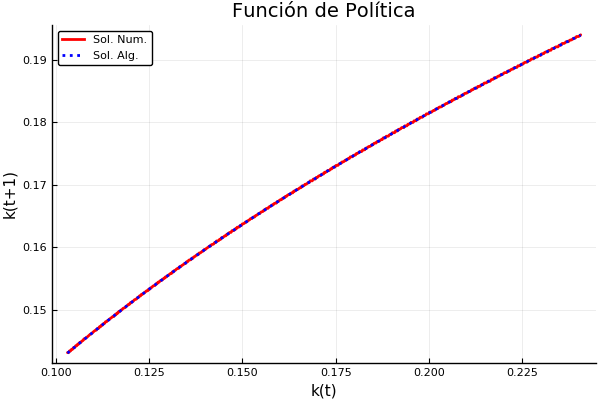

In [11]:
plot(kgrid, [kdeci kdeci_cs], title = "Función de Política", 
     xlabel = "k(t)", ylabel = "k(t+1)", label=["Sol. Num." "Sol. Alg."], 
     linewidth = 2, grid = true, line=[:solid :dot], color=[:red :blue])

Función valor:

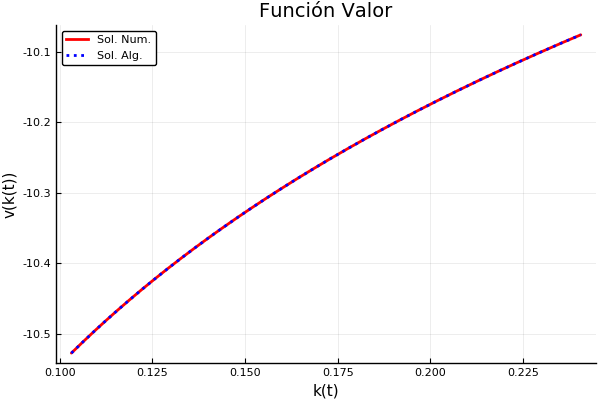

In [12]:
plot(kgrid, [val1 val_cs], title = "Función Valor", 
     xlabel = "k(t)", ylabel = "v(k(t))", label=["Sol. Num." "Sol. Alg."], 
     linewidth = 2, grid = true, line=[:solid :dot], color=[:red :blue])

Proceso de iteración de la función valor:

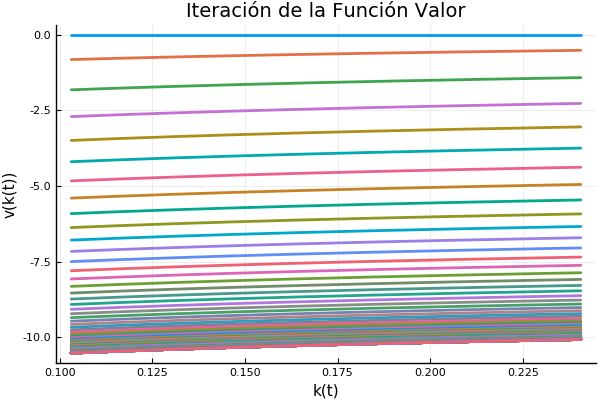

In [13]:
plot(kgrid, valiter, title = "Iteración de la Función Valor", 
     xlabel = "k(t)", ylabel = "v(k(t))", legend = false, linewidth = 2, 
     grid = true)